# Imports

In [145]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import h5py
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Tokenizer

In [146]:
class Tokenizer:
    def __init__(self, time_count: int = 260, note_count: int = 110, vel_count: int = 2):
        self.val_to_velo_id: dict = {i: i + 1 for i in range(vel_count)}
        self.val_to_note_id: dict = {i: i + 1 + vel_count for i in range(note_count)}
        self.val_to_time_id: dict = {i: i + 1 + vel_count + note_count for i in range(time_count)}

        self.velo_id_to_val: dict = {v: k for k, v in self.val_to_velo_id.items()}
        self.note_id_to_val: dict = {v: k for k, v in self.val_to_note_id.items()}
        self.time_id_to_val: dict = {v: k for k, v in self.val_to_time_id.items()}
        
        self.id_to_token: dict = {
            **{self.val_to_velo_id[i]: f'velo_{i}' for i in self.val_to_velo_id},
            **{self.val_to_note_id[i]: f'note_{i}' for i in self.val_to_note_id},
            **{self.val_to_time_id[i]: f'time_{i}' for i in self.val_to_time_id},
            0: '<pad>',
            vel_count + note_count + time_count + 1: '<bos>',
            vel_count + note_count + time_count + 2: '<eos>'
        }
        
        self.token_to_id: dict = {v: k for k, v in self.id_to_token.items()}
    

    def tuple_to_ids(self, tuple: tuple):
        return [self.val_to_time_id[tuple[0]], self.val_to_note_id[tuple[1]], self.val_to_velo_id[tuple[2]]]
    

    def tuple_list_to_ids(self, tuple_list: list[tuple]):
        l = []
        for t in tuple_list:
            l.extend(self.tuple_to_ids(t))
        return l


    def id_list_to_tuple_list(self, id_list: list[int]):
        l = []
        for i in range(0, len(id_list), 3):
            if i + 3 > len(id_list):
                break
            t = []
            for j, d in enumerate([self.time_id_to_val, self.note_id_to_val, self.velo_id_to_val]):
                if min(d) <= id_list[i+j] <= max(d):
                    t.append(d[id_list[i+j]])
                else:
                    t.append(-1)
            l.append(tuple(t))
        return l

# Dataset

In [147]:
# class FrameDataset(Dataset):
#     def __init__(self, image_midi_path_pairs: list[tuple], tokenizer: Tokenizer, max_leng: int, transform: transforms.Compose = None):
#         self.df = image_midi_path_pairs
#         self.tokenizer = tokenizer
#         self.transform = transform if transform else transforms.ToTensor()
#         self.max_leng = max_leng

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         image_path = self.df.iloc[idx]['image']
#         midi_path = self.df.iloc[idx]['midi']

#         image = Image.open(image_path).convert('L')
#         image = self.transform(image)

#         midi = pd.read_csv(midi_path)
#         midi['time'] = midi['time'] // 100
#         midi['velocity'] = (midi['velocity'] > 0).astype(int)
#         midi = midi.values.tolist()
#         midi = self.tokenizer.tuple_list_to_ids(midi)
#         midi.insert(0, self.tokenizer.token_to_id['<bos>'])
#         midi.append(self.tokenizer.token_to_id['<eos>'])
#         midi.extend([self.tokenizer.token_to_id['<pad>']] * (self.max_leng - len(midi)))
#         midi = torch.tensor(midi, dtype=torch.long)

#         return image, midi

In [148]:
class Collate:
    def __init__(self, pad_id: int):
        self.pad_id = pad_id

    def __call__(self, batch):
        images, midis = zip(*batch)
        images = torch.stack(images)
        midis = pad_sequence(midis, batch_first=True, padding_value=self.pad_id)
        return images, midis


class DatasetPathLoader:
    def __init__(self, h5_path: str, max_len, min_note: int = 0, max_note: int = 110):
        self.h5_path = h5_path
        self.data = []
        with h5py.File(h5_path, 'r') as h5:
            for piece_name in h5.keys():
                piece_group = h5[piece_name]
                for chunk_name in piece_group.keys():
                    chunk_group = piece_group[chunk_name]
                    meta = chunk_group['meta']
                    if meta[0] >= min_note and meta[1] <= max_note and meta[2] <= max_len / 3 - 1 and meta[2] > 0:
                        self.data.append((piece_name, chunk_name))


class H5Dataset(Dataset):
    def __init__(self, h5_path: str, data_paths: list[tuple], tokenizer: Tokenizer, transform: transforms.Compose = None):
        self.h5_path = h5_path
        self.tokenizer = tokenizer
        self.data = data_paths
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as h5:
            piece_name, chunk_name = self.data[idx]
            piece_group = h5[piece_name]
            chunk_group = piece_group[chunk_name]

            image = chunk_group['image'][:]
            image = self.transform(image)
            
            midi = chunk_group['midi'][:]
            midi[:, 0] = midi[:, 0] // 10
            midi[:, 2] = (midi[:, 2] > 0).astype(np.uint8)
            midi = midi.tolist()
            midi = self.tokenizer.tuple_list_to_ids(midi)
            midi.insert(0, self.tokenizer.token_to_id['<bos>'])
            midi.append(self.tokenizer.token_to_id['<eos>'])

        return image, torch.tensor(midi)

# Helpers

### progress bar

In [149]:
class ProgressBar:
    def __init__(self, total: int):
        self.total = total
        self.current = 0
        self.last_progress = 0
        self.start_time = time.time()

    def update(self, current: int, epochs: str):
        self.current = current
        progress = (self.current / self.total) * 100
        if int(progress) > self.last_progress:
            elapsed_time = time.time() - self.start_time
            print(
                f'\rEpoch: {epochs.rjust(7)} {str(int(progress)).rjust(3)}% | Elapsed: {str(int(elapsed_time)).rjust(3)}s', end='')
            self.last_progress = int(progress)

### metrics tracker

In [150]:
class MetricsTracker:
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def update(self, loss: float, accuracy: float):
        self.losses.append(loss)
        self.accuracies.append(accuracy)

    def get_average_loss(self):
        return sum(self.losses) / len(self.losses) if self.losses else 0.0

    def get_average_accuracy(self):
        return sum(self.accuracies) / len(self.accuracies) if self.accuracies else 0.0

### validator

In [151]:
class Validator:
    def __init__(self, model: nn.Module, criterion: nn.CrossEntropyLoss, device: torch.device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader: DataLoader) -> tuple:
        self.model.eval()
        metrics_tracker = MetricsTracker()

        with torch.no_grad():
            for image, midi in val_loader:
                image: torch.Tensor = image.to(self.device)
                midi: torch.Tensor = midi.to(self.device)

                input_tokens: torch.Tensor = midi[:, :-1]
                target_tokens: torch.Tensor = midi[:, 1:]
                target_tokens = target_tokens.reshape(-1)

                output: torch.Tensor = self.model(image, input_tokens)
                output = output.reshape(-1, output.shape[-1])

                loss: torch.Tensor = self.criterion(output, target_tokens)
                accuracy = (output.argmax(dim=1) ==
                            target_tokens).float().mean().item()

                metrics_tracker.update(loss.item(), accuracy)

        avg_loss = metrics_tracker.get_average_loss()
        avg_accuracy = metrics_tracker.get_average_accuracy()

        return avg_loss, avg_accuracy

### validator with outputs

In [152]:
class ValidatorWithOutputs:
    def __init__(self, model: nn.Module, criterion: nn.CrossEntropyLoss, device: torch.device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader: DataLoader) -> tuple:
        self.model.eval()
        outputs = []

        with torch.no_grad():
            for image, midi in val_loader:
                image: torch.Tensor = image.to(self.device)
                midi: torch.Tensor = midi.to(self.device)

                input_tokens: torch.Tensor = midi[:, :-1]
                target_tokens: torch.Tensor = midi[:, 1:]
                target_tokens = target_tokens.reshape(-1)

                output: torch.Tensor = self.model(image, input_tokens)
                output = output.reshape(-1, output.shape[-1])

                predicted = output.argmax(dim=1).cpu().tolist()
                expected = target_tokens.cpu().tolist()

                outputs.append((predicted, expected))

        return outputs

### positional encoding

In [153]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor):
        x = x + self.pe[:, :x.size(1)]
        return x

### history

In [154]:
class TrainingHistory:
    def __init__(self):
        self.history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }

    def update(self, train_loss: float, train_accuracy: float, val_loss: float, val_accuracy: float):
        self.history['train_loss'].append(train_loss)
        self.history['train_accuracy'].append(train_accuracy)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

    def get_history(self):
        return self.history

    def plot(self):
        epochs = range(1, len(self.history['train_loss']) + 1)
        plt.figure(figsize=(12, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_accuracy'], label='Train Accuracy')
        plt.plot(epochs, self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

### early topping

In [155]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Train

In [156]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device = device,
    history: TrainingHistory = None,
    early_stopping: EarlyStopping = None
):
    for epoch in range(epochs):
        progress_bar = ProgressBar(len(train_loader))
        metrics_tracker = MetricsTracker()
        validator = Validator(model, criterion, device)
        model.train()

        for i, (image, midi) in enumerate(train_loader):
            image: torch.Tensor = image.to(device)
            midi: torch.Tensor = midi.to(device)

            input_tokens = midi[:, :-1]
            target_tokens = midi[:, 1:]
            target_tokens = target_tokens.reshape(-1)

            output: torch.Tensor = model(image, input_tokens)
            output = output.reshape(-1, output.shape[-1])

            loss: torch.Tensor = criterion(output, target_tokens)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accuracy = (output.argmax(dim=1) == target_tokens).float().mean().item()
            metrics_tracker.update(loss.item(), accuracy)

            progress_bar.update(i + 1, f'{epoch + 1}/{epochs}')

        print(f' | loss: {metrics_tracker.get_average_loss():.4f} - acc: {metrics_tracker.get_average_accuracy():.4f}', end='')
        val_loss, val_acc = validator.validate(val_loader)
        print(f' | val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')

        if history:
            history.update(metrics_tracker.get_average_loss(), metrics_tracker.get_average_accuracy(), val_loss, val_acc)
        
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

# Model

In [157]:
class PianoTranscriber(nn.Module):
    def __init__(
        self,
        input_size: int,
        vocab_size: int,
        d_model: int = 128,
        nhead_en: int = 1,
        num_layers_en: int = 1,
        nhead_de: int = 1,
        num_layers_de: int = 1,
        dropout: float = 0.2  # Added dropout parameter
    ):
        super(PianoTranscriber, self).__init__()

        self.input_size = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, 200)

        # Add LayerNorm and Dropout after input_size
        self.input_norm = nn.LayerNorm(d_model)
        self.input_dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead_en, dropout=dropout, norm_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers_en)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model, nhead_de, dropout=dropout, norm_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers_de)

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_decoder = PositionalEncoding(d_model, 1500)

        # Add LayerNorm and Dropout after embedding
        self.embedding_norm = nn.LayerNorm(d_model)
        self.embedding_dropout = nn.Dropout(dropout)

        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        src = src.flatten(1, 2)
        src = src.permute(0, 2, 1)
        src = self.input_size(src)

        # Apply LayerNorm and Dropout after input_size
        src = self.input_norm(src)
        src = self.input_dropout(src)

        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2)
        memory = self.encoder(src)

        tgt = self.embedding(tgt)

        # Apply LayerNorm and Dropout after embedding
        tgt = self.embedding_norm(tgt)
        tgt = self.embedding_dropout(tgt)

        tgt = self.pos_decoder(tgt)
        tgt = tgt.permute(1, 0, 2)

        tgt_mask = self.generate_square_subsequent_mask(
            tgt.size(0)).to(tgt.device)

        output: torch.Tensor = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = self.output(output)
        output = output.permute(1, 0, 2)
        return output

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

# Example

### Prep

In [158]:
h5_path = 'dataset_big.h5'
model_name = 'model_big'
MAX_LEN = 400
tokenizer = Tokenizer(time_count=260)

In [159]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 128)),
    transforms.Normalize((0.5,), (0.5,))
])

In [160]:
path_loader = DatasetPathLoader(h5_path, MAX_LEN)


In [ ]:
data = path_loader.data
# data = random.sample(path_loader.data, 8000)
print(f"Total data: {len(data)}")
train_data, val_data = train_test_split(data, test_size=0.1)
val_data, test_data = train_test_split(val_data, test_size=0.1)

Total data: 8000


In [162]:
train_dataset = H5Dataset(h5_path, train_data, tokenizer, transform)
val_dataset = H5Dataset(h5_path, val_data, tokenizer, transform)
collate = Collate(tokenizer.token_to_id['<pad>'])
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False, collate_fn=collate)

### Training

In [163]:
model = PianoTranscriber(
    input_size = 256, 
    vocab_size = len(tokenizer.id_to_token),
    d_model = 128, 
    nhead_en = 1, 
    num_layers_en = 1, 
    nhead_de = 1, 
    num_layers_de = 1
).to(device)

# weights = torch.ones(len(tokenizer.id_to_token)).to(device)
# for note_id in tokenizer.val_to_note_id.values():
#     weights[note_id] = 16
# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id['<pad>'], weight=weights).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id['<pad>']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = TrainingHistory()
early_stopping = EarlyStopping(patience=10, path=f'{model_name}_{time.strftime("%Y%m%d-%H%M%S")}.pt')

In [ ]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=50, device=device, history=history, early_stopping=early_stopping)

Epoch:    1/15 100% | Elapsed:  14s | loss: 3.3168 - acc: 0.0889 | val_loss: 2.6675 - val_acc: 0.1107
Epoch:    2/15 100% | Elapsed:  14s | loss: 2.5617 - acc: 0.1143 | val_loss: 2.1869 - val_acc: 0.1356
Epoch:    3/15 100% | Elapsed:  14s | loss: 2.2621 - acc: 0.1273 | val_loss: 1.9783 - val_acc: 0.1450
Epoch:    4/15 100% | Elapsed:  14s | loss: 2.0938 - acc: 0.1367 | val_loss: 1.8424 - val_acc: 0.1553
Epoch:    5/15 100% | Elapsed:  15s | loss: 1.9826 - acc: 0.1431 | val_loss: 1.7556 - val_acc: 0.1610
Epoch:    6/15 100% | Elapsed:  15s | loss: 1.9136 - acc: 0.1479 | val_loss: 1.7073 - val_acc: 0.1660
Epoch:    7/15 100% | Elapsed:  14s | loss: 1.8695 - acc: 0.1521 | val_loss: 1.6748 - val_acc: 0.1701
Epoch:    8/15 100% | Elapsed:  15s | loss: 1.8399 - acc: 0.1545 | val_loss: 1.6512 - val_acc: 0.1744
Epoch:    9/15 100% | Elapsed:  15s | loss: 1.8143 - acc: 0.1566 | val_loss: 1.6312 - val_acc: 0.1767
Epoch:   10/15 100% | Elapsed:  15s | loss: 1.7943 - acc: 0.1603 | val_loss: 1.613

# Tests

In [165]:
def get_param_stats(outputs):
    acc = np.zeros((len(outputs), 3))
    mean = np.zeros((len(outputs), 3))
    std = np.zeros((len(outputs), 3))
    for i, el in enumerate(outputs):
        el = np.array(el)
        el = el[:, :-1]
        el = el.reshape(2, -1, 3)
        acc[i] = (el[0] == el[1]).mean(axis=0)
        mean[i] = np.abs(el[0] - el[1]).mean(axis=0)
        std[i] = np.sqrt(((el[0] - el[1]) ** 2).mean(axis=0))
    acc = np.mean(acc, axis=0)
    mean = np.mean(mean, axis=0)
    std = np.mean(std, axis=0)
    return {'acc': acc.round(3).tolist(), 'mean': mean.round(3).tolist(), 'std': std.round(3).tolist()}

In [166]:
test_dataset = H5Dataset(h5_path, test_data, tokenizer, transform)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=4, shuffle=False, collate_fn=collate)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id['<pad>']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

val_with_outs = ValidatorWithOutputs(model, criterion, device)
outputs = val_with_outs.validate(test_loader)
param_stats = get_param_stats(outputs)

for i in param_stats:
    print(i, param_stats[i])

for i, (predicted, expected) in enumerate(outputs):
    if i > 4:
        break
    print(f"Predicted: {predicted}")
    print(f"Expected: {expected}")
    print()

acc [0.163, 0.488, 0.595]
mean [14.428, 5.727, 0.405]
std [19.282, 9.571, 0.62]
Predicted: [114, 51, 2, 123, 51, 2, 124, 51, 2, 124, 51, 2, 124, 51, 2, 124, 52, 2, 151, 52, 1, 128, 64, 1, 151, 52, 1, 145, 56, 2, 226, 56, 2, 227, 52, 2, 283, 56, 1, 283, 68, 2, 374, 68, 2, 374, 59, 2, 322, 71, 1, 324, 68, 1, 325, 68, 2, 326, 61, 2, 350, 61, 1, 374, 68, 2, 374]
Expected: [114, 63, 2, 115, 52, 1, 115, 64, 1, 120, 63, 1, 120, 51, 1, 126, 64, 2, 126, 52, 2, 126, 51, 2, 131, 51, 1, 225, 68, 2, 226, 56, 2, 251, 52, 1, 251, 56, 1, 257, 64, 1, 261, 68, 1, 320, 59, 2, 324, 64, 2, 324, 71, 2, 325, 68, 2, 349, 59, 1, 351, 61, 2, 368, 61, 1, 374]

Predicted: [134, 41, 1, 134, 41, 2, 134, 74, 2, 138, 74, 2, 136, 74, 2, 140, 74, 1, 141, 79, 2, 166, 75, 1, 167, 75, 2, 167, 75, 2, 168, 79, 2, 171, 79, 1, 171, 79, 1, 171, 79, 2, 175, 74, 2, 214, 74, 1, 214, 77, 2, 220, 77, 1, 220, 75, 2, 245, 72, 2, 245, 72, 2, 245, 75, 2, 245, 75, 2, 249, 75, 1, 249, 75, 1, 268, 75, 2, 270, 70, 2, 283, 74, 1, 283, 70, 2

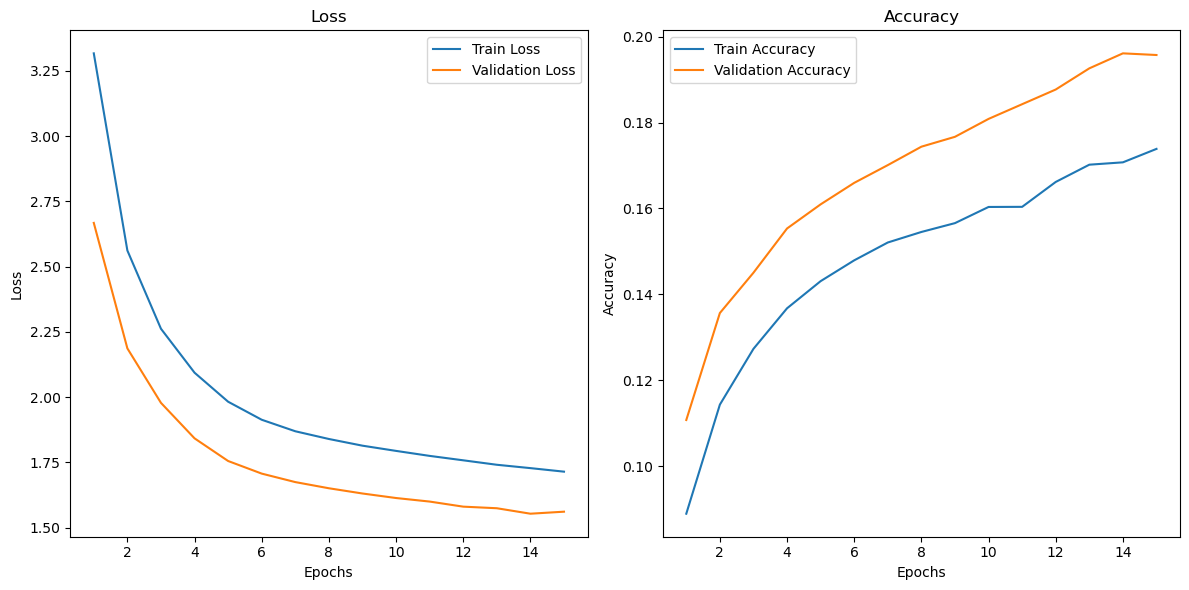

In [167]:
history.plot()

[80 84 80 84 80 75 75 75 75 80 75 80 75 72 72 72 72 75 72 75 60 72 68 68
 68 68 72 51 68 72 68 63 56 63 51 61 70 67 61 67 70 51 44 87 44 92 87 87
 92 84 87 84 84 60 56 51 87 84 84 87 84 80 80 80]


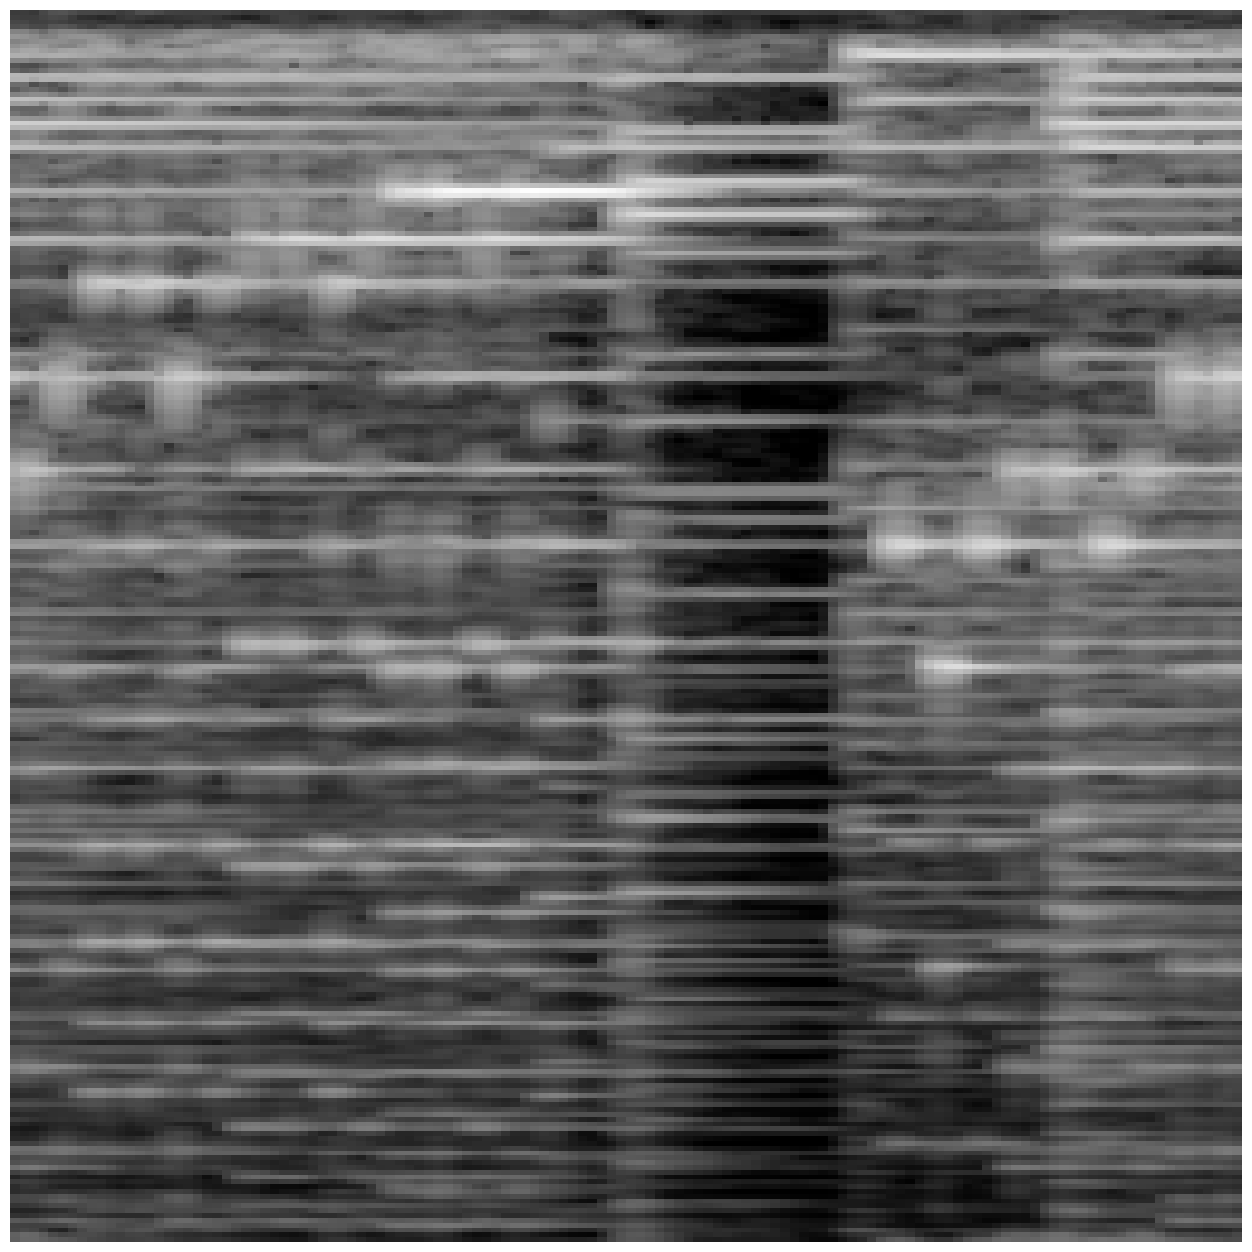

In [168]:
for i, (image, midi) in enumerate(train_loader):
    if i > 0:
        break
    last = (midi[0] == tokenizer.token_to_id['<eos>']).nonzero(as_tuple=True)[0].item()
    notes = tokenizer.id_list_to_tuple_list(midi[0][1:last].cpu().tolist())
    notes = np.array(notes)
    print(notes[:, 1])
    plt.figure(figsize=(16, 16))
    plt.imshow(image[0].cpu().squeeze(), cmap='gray', aspect=1/2, interpolation='nearest')
    plt.axis('off')
    plt.show()